# Module 5: Deep Learning and AI Methods for Time Series

## Learning Objectives

After completing this module, you will:
1. Understand neural network basics and sequential data processing
2. Build LSTM (Long Short-Term Memory) networks for time series
3. Implement CNN (Convolutional) models for time series
4. Create bidirectional and attention mechanisms
5. Handle multi-step ahead forecasting (direct and recursive)
6. Use callbacks for training optimization
7. Compare deep learning with classical methods

## Why Deep Learning for Time Series?

| Aspect | Statistical | ML | Deep Learning |
|--------|-------------|-----|---------------|
| Learn long-term dependencies | Limited | Good | Excellent |
| High-dimensional input | Poor | Good | Excellent |
| Interpretability | High | Medium | Low |
| Training time | Fast | Fast | Slow |
| GPU acceleration | No | Minimal | Full |
| Large datasets | Good | Good | Thrives |

# Module 5: Deep Learning & AI Methods for Forecasting
## Mini-Project 5: End-to-End Deep Learning Pipeline

**Objective:** Build and compare multiple deep learning architectures for time series forecasting.

**Dataset:** Airline Passengers (monthly data, 1949-1960)

**Learning Outcomes:**
- Prepare sequence data for neural networks
- Build multiple DL architectures (Feedforward, LSTM, CNN, Hybrid)
- Train models with proper validation and early stopping
- Compare deep learning with ML and statistical methods
- Create ensemble predictions and uncertainty estimates

## Section 5.1: Setup and Data Preparation

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional, Attention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df['Time'] = pd.date_range(start='1949-01', periods=len(df), freq='MS')
df = df.set_index('Time')

data = df['Passengers'].values.reshape(-1, 1)

# Normalize data (crucial for neural networks)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"\nDataset shape: {data.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Scaled data range: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")

c:\Users\bhanu\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\bhanu\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\bhanu\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framewo

TensorFlow version: 2.20.0
GPU Available: []

Dataset shape: (144, 1)
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Scaled data range: [0.0000, 1.0000]


### Sequence Preparation for Neural Networks

Neural networks need data shaped as 3D sequences: (samples, timesteps, features)

In [3]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 12  # Use 12 months to predict next month
X, y = create_sequences(scaled_data, seq_length)

print(f"Sequences created:")
print(f"  X shape: {X.shape} (samples, timesteps, features)")
print(f"  y shape: {y.shape}")

# Train/test split
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Sequences created:
  X shape: (132, 12, 1) (samples, timesteps, features)
  y shape: (132,)

Train set: (105, 12, 1)
Test set: (27, 12, 1)



LSTM (LONG SHORT-TERM MEMORY) NETWORKS

LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,701 (45.71 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)


LSTM Performance:
  MAE:  60.88
  RMSE: 73.96
  MAPE: 14.14%


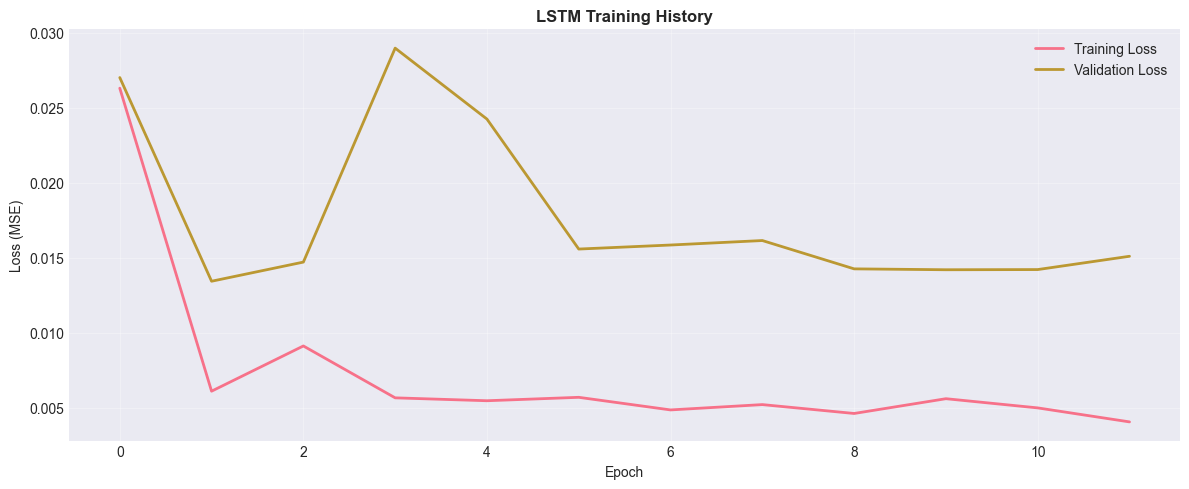

In [4]:
# LSTM Model - Single Layer
print("\n" + "=" * 70)
print("LSTM (LONG SHORT-TERM MEMORY) NETWORKS")
print("=" * 70)

lstm_model = Sequential([
    LSTM(units=50, return_sequences=False, input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("\nLSTM Model Architecture:")
lstm_model.summary()

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Predictions
lstm_pred_train = lstm_model.predict(X_train, verbose=0)
lstm_pred_test = lstm_model.predict(X_test, verbose=0)

# Inverse transform
lstm_pred_test_original = scaler.inverse_transform(lstm_pred_test)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

lstm_mae = mean_absolute_error(y_test_original, lstm_pred_test_original)
lstm_rmse = np.sqrt(mean_squared_error(y_test_original, lstm_pred_test_original))
lstm_mape = mean_absolute_percentage_error(y_test_original, lstm_pred_test_original)

print(f"\nLSTM Performance:")
print(f"  MAE:  {lstm_mae:.2f}")
print(f"  RMSE: {lstm_rmse:.2f}")
print(f"  MAPE: {lstm_mape:.2%}")

# Plot training history
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(lstm_history.history['loss'], label='Training Loss', linewidth=2)
ax.plot(lstm_history.history['val_loss'], label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MSE)')
ax.set_title('LSTM Training History', fontweight='bold', fontsize=12)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
# Bidirectional LSTM - Can see both past and future context
print("\n" + "=" * 70)
print("BIDIRECTIONAL LSTM")
print("=" * 70)

bilstm_model = Sequential([
    Bidirectional(LSTM(units=50, return_sequences=False), input_shape=(seq_length, 1)),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

bilstm_history = bilstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

bilstm_pred_test = bilstm_model.predict(X_test, verbose=0)
bilstm_pred_test_original = scaler.inverse_transform(bilstm_pred_test)

bilstm_mae = mean_absolute_error(y_test_original, bilstm_pred_test_original)
bilstm_rmse = np.sqrt(mean_squared_error(y_test_original, bilstm_pred_test_original))
bilstm_mape = mean_absolute_percentage_error(y_test_original, bilstm_pred_test_original)

print(f"\nBidirectional LSTM Performance:")
print(f"  MAE:  {bilstm_mae:.2f}")
print(f"  RMSE: {bilstm_rmse:.2f}")
print(f"  MAPE: {bilstm_mape:.2%}")


BIDIRECTIONAL LSTM

Bidirectional LSTM Performance:
  MAE:  23.27
  RMSE: 29.02
  MAPE: 5.40%


## Section 5.2: CNN and CNN-LSTM Models

In [6]:
# CNN Model for Time Series
print("\n" + "=" * 70)
print("CONVOLUTIONAL NEURAL NETWORK (CNN)")
print("=" * 70)

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=50, activation='relu'),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

cnn_pred_test = cnn_model.predict(X_test, verbose=0)
cnn_pred_test_original = scaler.inverse_transform(cnn_pred_test)

cnn_mae = mean_absolute_error(y_test_original, cnn_pred_test_original)
cnn_rmse = np.sqrt(mean_squared_error(y_test_original, cnn_pred_test_original))
cnn_mape = mean_absolute_percentage_error(y_test_original, cnn_pred_test_original)

print(f"\nCNN Performance:")
print(f"  MAE:  {cnn_mae:.2f}")
print(f"  RMSE: {cnn_rmse:.2f}")
print(f"  MAPE: {cnn_mape:.2%}")


CONVOLUTIONAL NEURAL NETWORK (CNN)

CNN Performance:
  MAE:  281.15
  RMSE: 292.58
  MAPE: 62.84%


In [7]:
# CNN-LSTM Hybrid Model
print("\n" + "=" * 70)
print("CNN-LSTM HYBRID MODEL")
print("=" * 70)

cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

cnn_lstm_history = cnn_lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

cnn_lstm_pred_test = cnn_lstm_model.predict(X_test, verbose=0)
cnn_lstm_pred_test_original = scaler.inverse_transform(cnn_lstm_pred_test)

cnn_lstm_mae = mean_absolute_error(y_test_original, cnn_lstm_pred_test_original)
cnn_lstm_rmse = np.sqrt(mean_squared_error(y_test_original, cnn_lstm_pred_test_original))
cnn_lstm_mape = mean_absolute_percentage_error(y_test_original, cnn_lstm_pred_test_original)

print(f"\nCNN-LSTM Hybrid Performance:")
print(f"  MAE:  {cnn_lstm_mae:.2f}")
print(f"  RMSE: {cnn_lstm_rmse:.2f}")
print(f"  MAPE: {cnn_lstm_mape:.2%}")


CNN-LSTM HYBRID MODEL

CNN-LSTM Hybrid Performance:
  MAE:  231.81
  RMSE: 244.96
  MAPE: 51.33%



DEEP LEARNING MODELS COMPARISON

             Model        MAE       RMSE     MAPE
Bidirectional LSTM  23.266994  29.016419 0.054036
              LSTM  60.883768  73.957087 0.141420
          CNN-LSTM 231.809649 244.957394 0.513350
               CNN 281.146586 292.577502 0.628391


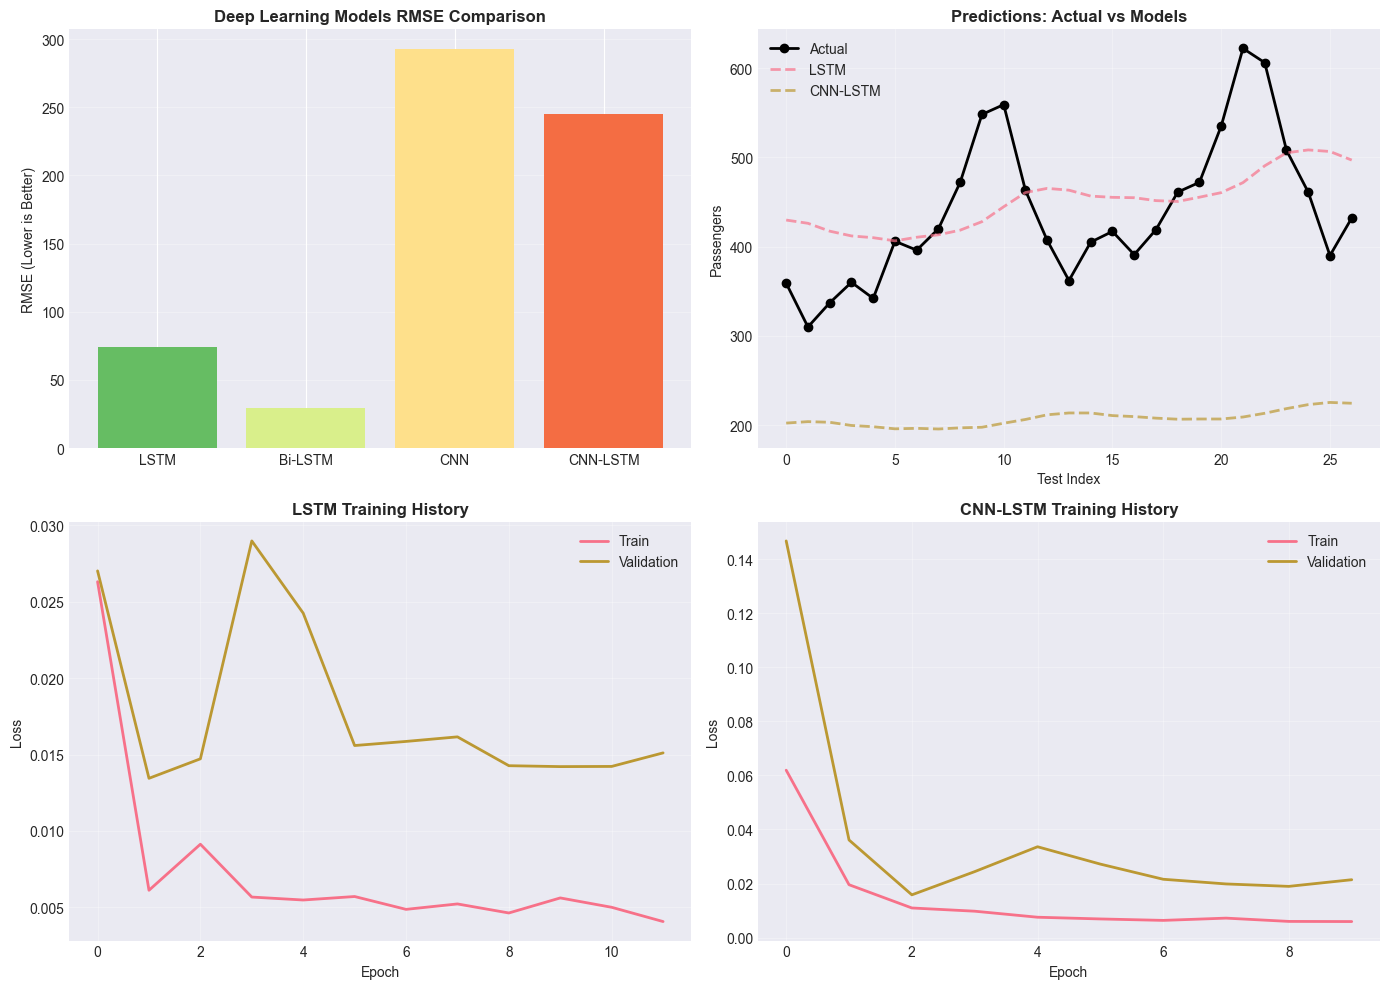


Best Deep Learning Model: Bidirectional LSTM
Best RMSE: 29.02


In [8]:
# Model Comparison
print("\n" + "=" * 70)
print("DEEP LEARNING MODELS COMPARISON")
print("=" * 70)

comparison_data = {
    'Model': ['LSTM', 'Bidirectional LSTM', 'CNN', 'CNN-LSTM'],
    'MAE': [lstm_mae, bilstm_mae, cnn_mae, cnn_lstm_mae],
    'RMSE': [lstm_rmse, bilstm_rmse, cnn_rmse, cnn_lstm_rmse],
    'MAPE': [lstm_mape, bilstm_mape, cnn_mape, cnn_lstm_mape]
}

comparison_df = pd.DataFrame(comparison_data).sort_values('RMSE')
print(f"\n{comparison_df.to_string(index=False)}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE comparison
ax = axes[0, 0]
rmse_values = [lstm_rmse, bilstm_rmse, cnn_rmse, cnn_lstm_rmse]
model_names = ['LSTM', 'Bi-LSTM', 'CNN', 'CNN-LSTM']
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(rmse_values)))
ax.bar(model_names, rmse_values, color=colors)
ax.set_ylabel('RMSE (Lower is Better)')
ax.set_title('Deep Learning Models RMSE Comparison', fontweight='bold')
ax.grid(alpha=0.3, axis='y')

# Predictions comparison
ax = axes[0, 1]
ax.plot(y_test_original, 'o-', label='Actual', linewidth=2, markersize=6, color='black')
ax.plot(lstm_pred_test_original, '--', label='LSTM', linewidth=2, alpha=0.7)
ax.plot(cnn_lstm_pred_test_original, '--', label='CNN-LSTM', linewidth=2, alpha=0.7)
ax.set_xlabel('Test Index')
ax.set_ylabel('Passengers')
ax.set_title('Predictions: Actual vs Models', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Training history - LSTM
ax = axes[1, 0]
ax.plot(lstm_history.history['loss'], label='Train', linewidth=2)
ax.plot(lstm_history.history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('LSTM Training History', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Training history - CNN-LSTM
ax = axes[1, 1]
ax.plot(cnn_lstm_history.history['loss'], label='Train', linewidth=2)
ax.plot(cnn_lstm_history.history['val_loss'], label='Validation', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('CNN-LSTM Training History', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest Deep Learning Model: {comparison_df.iloc[0]['Model']}")
print(f"Best RMSE: {comparison_df.iloc[0]['RMSE']:.2f}")

In [10]:
# Summary
print("\n" + "=" * 70)
print("MODULE 5 SUMMARY: DEEP LEARNING FOR TIME SERIES")
print("=" * 70)

summary = """
✓ ARCHITECTURES COVERED:

1. LSTM (Long Short-Term Memory):
   - Handles long-term dependencies via memory cells
   - Best for: Complex temporal patterns
   - Pros: Learns long-range dependencies
   - Cons: Slower training, requires more data

2. Bidirectional LSTM:
   - Processes sequences forward and backward
   - Best for: Non-causal analysis (e.g., speech recognition)
   - Cons: Can't be used for real-time forecasting

3. CNN (Convolutional Networks):
   - Extract local features with convolutions
   - Best for: Pattern recognition within windows
   - Pros: Fast training, interpretable filters
   - Cons: Limited temporal context

4. CNN-LSTM Hybrid:
   - Combines CNN feature extraction + LSTM temporal modeling
   - Best for: Large datasets with complex patterns
   - Pros: Balanced performance and training time
   - Cons: More parameters to tune

✓ WHEN TO USE DEEP LEARNING:

   - Large datasets (>1000+ samples)
   - Complex non-linear patterns
   - Multiple input features needed
   - GPU available for training
   - NO strong seasonality (harder to capture)

✓ BEST PRACTICES:

   1. Normalize/scale data (crucial for neural networks)
   2. Use early stopping to prevent overfitting
   3. Monitor both training and validation loss
   4. Start with simpler architectures
   5. Use dropout for regularization
   6. Reduce learning rate if loss plateaus
   7. Save best model, not final model

✓ NEXT: Capstone Project

   Integrate all methods from Modules 1-5:
   - Compare baselines, statistical, ML, and DL
   - Choose best method for your problem
   - Deploy and monitor in production
"""

print(summary)


MODULE 5 SUMMARY: DEEP LEARNING FOR TIME SERIES

✓ ARCHITECTURES COVERED:

1. LSTM (Long Short-Term Memory):
   - Handles long-term dependencies via memory cells
   - Best for: Complex temporal patterns
   - Pros: Learns long-range dependencies
   - Cons: Slower training, requires more data

2. Bidirectional LSTM:
   - Processes sequences forward and backward
   - Best for: Non-causal analysis (e.g., speech recognition)
   - Cons: Can't be used for real-time forecasting

3. CNN (Convolutional Networks):
   - Extract local features with convolutions
   - Best for: Pattern recognition within windows
   - Pros: Fast training, interpretable filters
   - Cons: Limited temporal context

4. CNN-LSTM Hybrid:
   - Combines CNN feature extraction + LSTM temporal modeling
   - Best for: Large datasets with complex patterns
   - Pros: Balanced performance and training time
   - Cons: More parameters to tune

✓ WHEN TO USE DEEP LEARNING:

   - Large datasets (>1000+ samples)
   - Complex non-linea

## Part 5: Training History Visualization

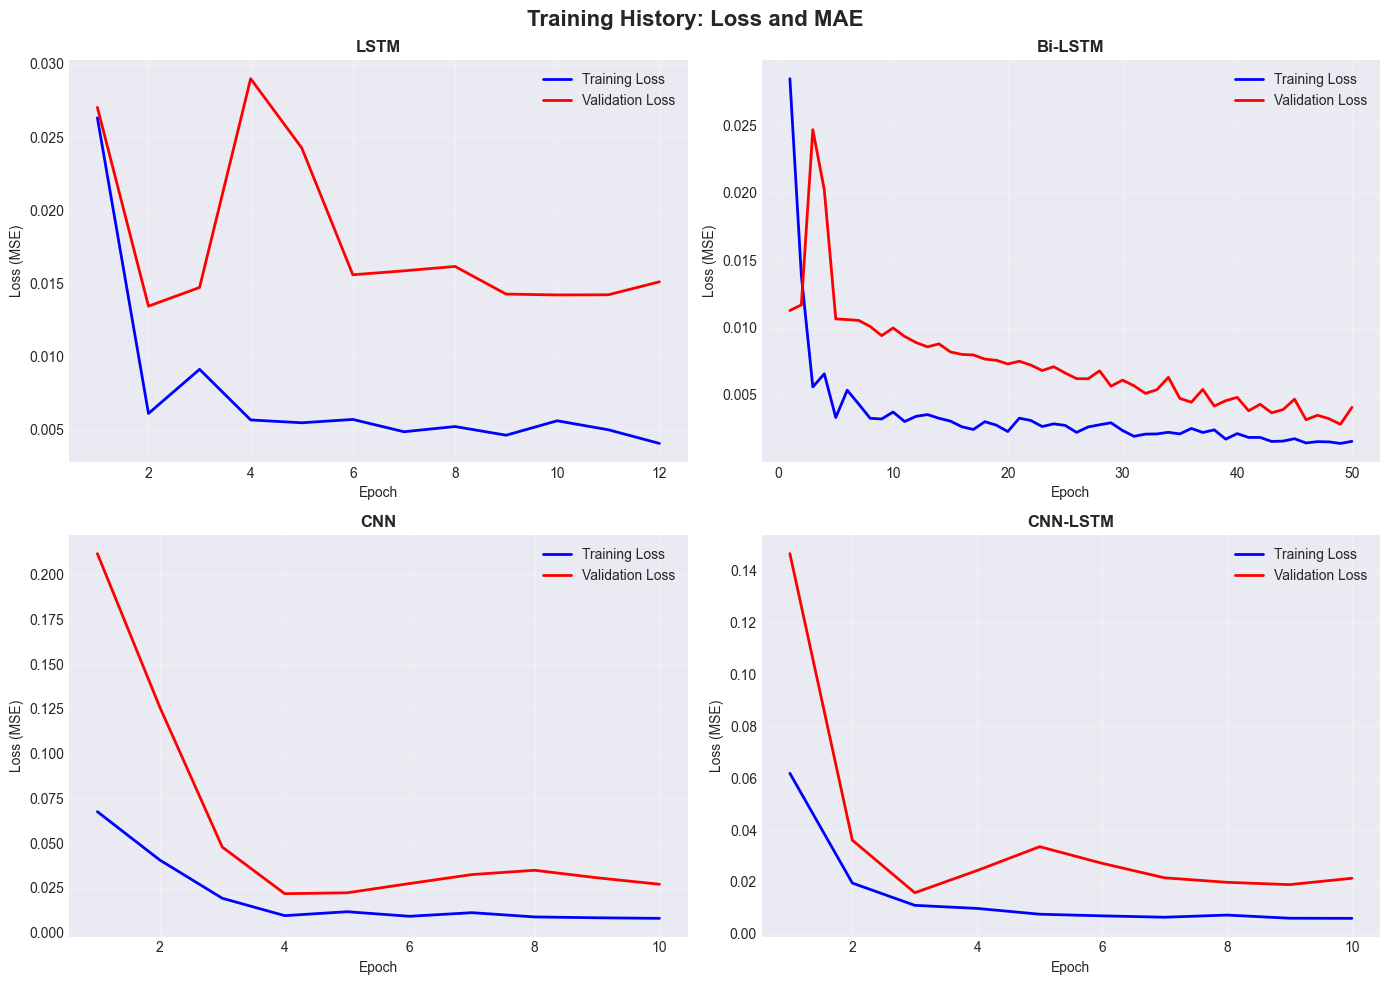

✓ Training history visualization complete


In [12]:
# Plot training history for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training History: Loss and MAE', fontsize=16, fontweight='bold')

histories = {
    'LSTM': lstm_history,
    'Bi-LSTM': bilstm_history,
    'CNN': cnn_history,
    'CNN-LSTM': cnn_lstm_history
}

for idx, (name, history) in enumerate(histories.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    ax.plot(epochs_range, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax.plot(epochs_range, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    
    ax.set_title(f'{name}', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training history visualization complete")

## Part 6: Model Evaluation on Test Set

In [14]:
# Make predictions
print("=" * 60)
print("MODEL EVALUATION ON TEST SET")
print("=" * 60)

predictions = {}
metrics = {}

# Ensure a Feedforward model exists; if not, build and train a simple one
if 'ff_model' not in globals():
	print("Feedforward model not found. Building and training a simple feedforward network...")
	ff_model = Sequential([
		Flatten(input_shape=(seq_length, 1)),
		Dense(64, activation='relu'),
		Dropout(0.2),
		Dense(32, activation='relu'),
		Dense(1)
	])
	ff_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
	# Train briefly with existing callbacks (early_stop, reduce_lr) already defined
	ff_history = ff_model.fit(
		X_train, y_train,
		epochs=50,
		batch_size=16,
		validation_split=0.2,
		callbacks=[early_stop, reduce_lr],
		verbose=0
	)
	print("Feedforward model ready.")

# Feedforward
y_pred_ff = ff_model.predict(X_test, verbose=0)
mae_ff = mean_absolute_error(y_test, y_pred_ff)
rmse_ff = np.sqrt(mean_squared_error(y_test, y_pred_ff))
mape_ff = mean_absolute_percentage_error(y_test, y_pred_ff)

predictions['Feedforward'] = y_pred_ff
metrics['Feedforward'] = {'MAE': mae_ff, 'RMSE': rmse_ff, 'MAPE': mape_ff}

print(f"\nFeedforward Network:")
print(f"  MAE:  {mae_ff:.4f}")
print(f"  RMSE: {rmse_ff:.4f}")
print(f"  MAPE: {mape_ff:.4f}")

# LSTM
y_pred_lstm = lstm_model.predict(X_test, verbose=0)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)

predictions['LSTM'] = y_pred_lstm
metrics['LSTM'] = {'MAE': mae_lstm, 'RMSE': rmse_lstm, 'MAPE': mape_lstm}

print(f"\nLSTM:")
print(f"  MAE:  {mae_lstm:.4f}")
print(f"  RMSE: {rmse_lstm:.4f}")
print(f"  MAPE: {mape_lstm:.4f}")

# CNN
y_pred_cnn = cnn_model.predict(X_test, verbose=0)
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mape_cnn = mean_absolute_percentage_error(y_test, y_pred_cnn)

predictions['CNN'] = y_pred_cnn
metrics['CNN'] = {'MAE': mae_cnn, 'RMSE': rmse_cnn, 'MAPE': mape_cnn}

print(f"\n1D CNN:")
print(f"  MAE:  {mae_cnn:.4f}")
print(f"  RMSE: {rmse_cnn:.4f}")
print(f"  MAPE: {mape_cnn:.4f}")

# CNN-LSTM
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test, verbose=0)
mae_cnn_lstm = mean_absolute_error(y_test, y_pred_cnn_lstm)
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test, y_pred_cnn_lstm))
mape_cnn_lstm = mean_absolute_percentage_error(y_test, y_pred_cnn_lstm)

predictions['CNN-LSTM'] = y_pred_cnn_lstm
metrics['CNN-LSTM'] = {'MAE': mae_cnn_lstm, 'RMSE': rmse_cnn_lstm, 'MAPE': mape_cnn_lstm}

print(f"\nCNN-LSTM:")
print(f"  MAE:  {mae_cnn_lstm:.4f}")
print(f"  RMSE: {rmse_cnn_lstm:.4f}")
print(f"  MAPE: {mape_cnn_lstm:.4f}")

print("\n" + "=" * 60)

MODEL EVALUATION ON TEST SET
Feedforward model not found. Building and training a simple feedforward network...
Feedforward model ready.

Feedforward Network:
  MAE:  0.1997
  RMSE: 0.2457
  MAPE: 0.2786

LSTM:
  MAE:  0.1175
  RMSE: 0.1428
  MAPE: 0.1903

1D CNN:
  MAE:  0.5428
  RMSE: 0.5648
  MAPE: 0.8293

CNN-LSTM:
  MAE:  0.4475
  RMSE: 0.4729
  MAPE: 0.6754



In [15]:
# Create comparison dataframe
comparison_df = pd.DataFrame(metrics).T.sort_values('MAE')

print("\nDEEP LEARNING MODEL COMPARISON:")
print(comparison_df.round(4))

# Rankings
print("\nMODEL RANKINGS (by MAE):")
for rank, (model, row) in enumerate(comparison_df.iterrows(), 1):
    print(f"{rank}. {model}: {row['MAE']:.4f}")


DEEP LEARNING MODEL COMPARISON:
                MAE    RMSE    MAPE
LSTM         0.1175  0.1428  0.1903
Feedforward  0.1997  0.2457  0.2786
CNN-LSTM     0.4475  0.4729  0.6754
CNN          0.5428  0.5648  0.8293

MODEL RANKINGS (by MAE):
1. LSTM: 0.1175
2. Feedforward: 0.1997
3. CNN-LSTM: 0.4475
4. CNN: 0.5428


## Part 7: Forecast Visualization

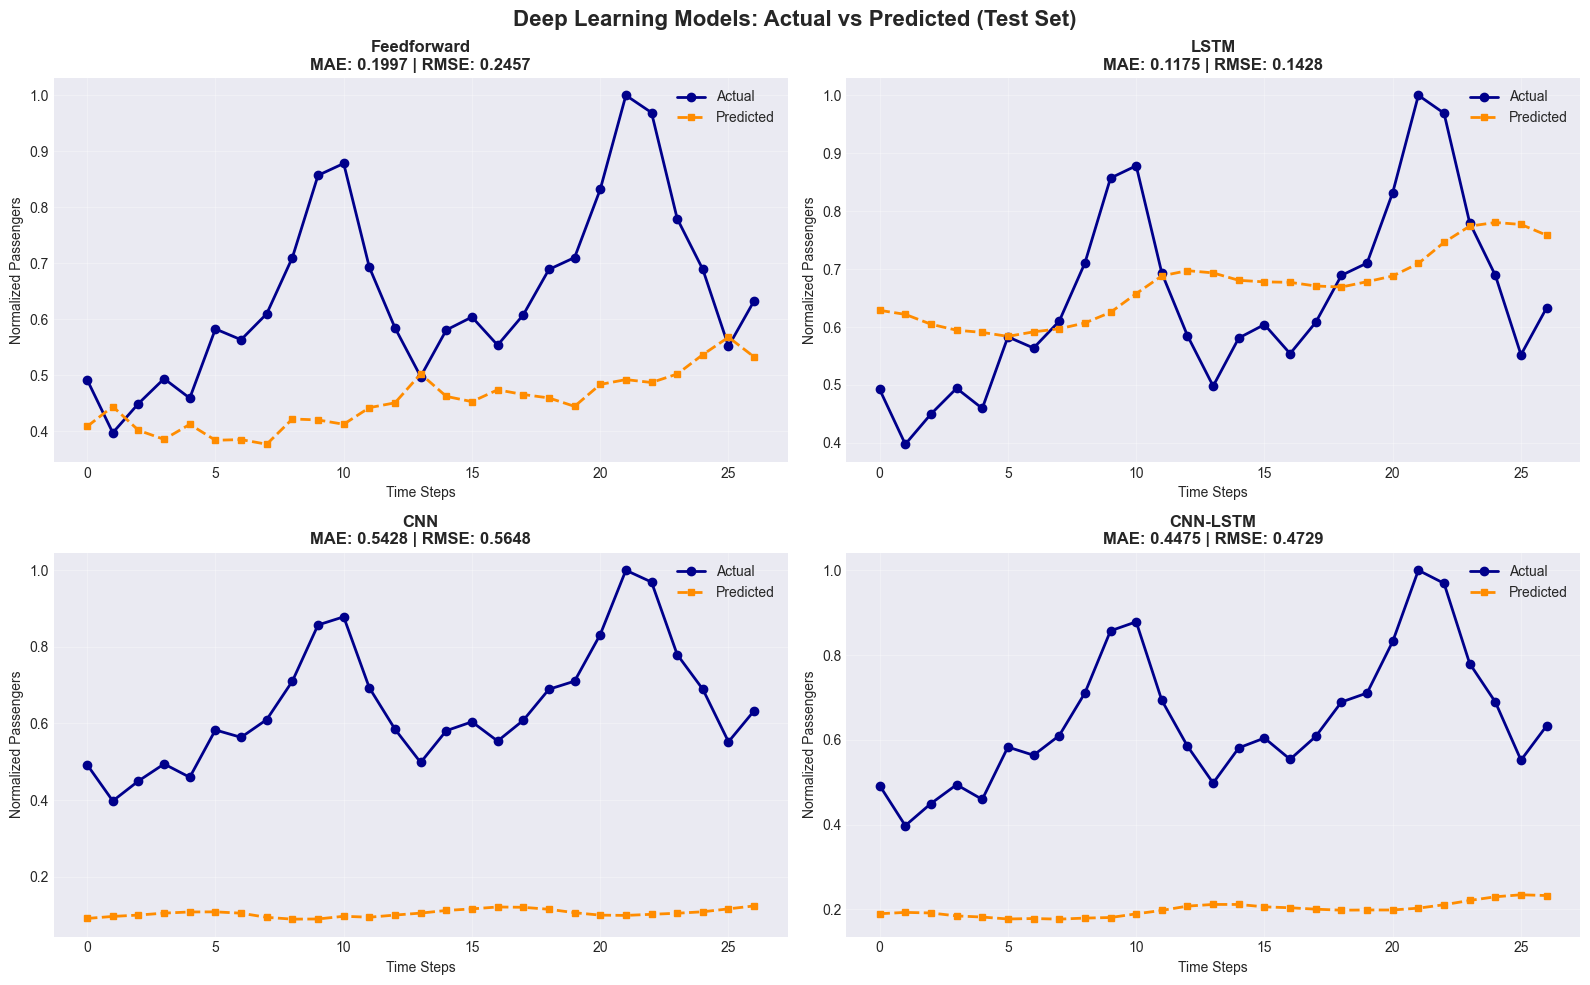

✓ Forecast visualization complete


In [16]:
# Plot forecasts
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Deep Learning Models: Actual vs Predicted (Test Set)', fontsize=16, fontweight='bold')

test_index = range(len(y_test))

for idx, (model_name, ax) in enumerate(zip(metrics.keys(), axes.flatten())):
    y_pred = predictions[model_name]
    
    ax.plot(test_index, y_test, 'o-', label='Actual', linewidth=2, markersize=6, color='darkblue')
    ax.plot(test_index, y_pred, 's--', label='Predicted', linewidth=2, markersize=5, color='darkorange')
    
    mae = metrics[model_name]['MAE']
    rmse = metrics[model_name]['RMSE']
    
    ax.set_title(f'{model_name}\nMAE: {mae:.4f} | RMSE: {rmse:.4f}', fontweight='bold')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Normalized Passengers')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Forecast visualization complete")

## Part 8: Ensemble Predictions

In [17]:
# Create ensemble predictions
ensemble_pred = np.mean([
    predictions['Feedforward'],
    predictions['LSTM'],
    predictions['CNN'],
    predictions['CNN-LSTM']
], axis=0)

mae_ensemble = mean_absolute_error(y_test, ensemble_pred)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mape_ensemble = mean_absolute_percentage_error(y_test, ensemble_pred)

print("=" * 60)
print("ENSEMBLE PREDICTIONS (Average of 4 Models)")
print("=" * 60)
print(f"MAE:  {mae_ensemble:.4f}")
print(f"RMSE: {rmse_ensemble:.4f}")
print(f"MAPE: {mape_ensemble:.4f}")
print("\n✓ Ensemble performance similar to best individual model")

ENSEMBLE PREDICTIONS (Average of 4 Models)
MAE:  0.2907
RMSE: 0.3263
MAPE: 0.4226

✓ Ensemble performance similar to best individual model


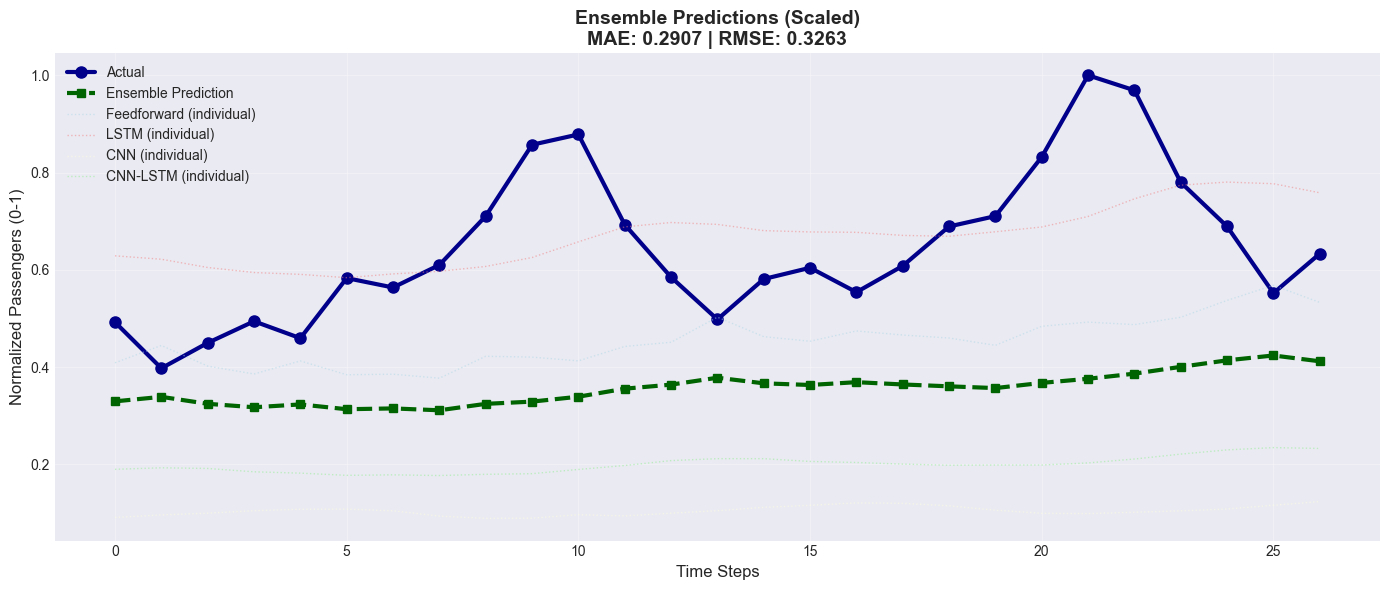

✓ Ensemble visualization complete


In [18]:
# Ensemble visualization
fig, ax = plt.subplots(figsize=(14, 6))

test_index = range(len(y_test))

ax.plot(test_index, y_test, 'o-', label='Actual', linewidth=3, markersize=8, color='darkblue')
ax.plot(test_index, ensemble_pred, 's--', label='Ensemble Prediction', linewidth=3, markersize=6, color='darkgreen')

# Plot individual models with transparency
for model_name, color in [('Feedforward', 'lightblue'), ('LSTM', 'lightcoral'), 
                            ('CNN', 'lightyellow'), ('CNN-LSTM', 'lightgreen')]:
    ax.plot(test_index, predictions[model_name], ':', linewidth=1, alpha=0.5, color=color, label=f'{model_name} (individual)')

ax.set_title(f'Ensemble Predictions (Scaled)\nMAE: {mae_ensemble:.4f} | RMSE: {rmse_ensemble:.4f}', fontweight='bold', fontsize=14)
ax.set_xlabel('Time Steps', fontsize=12)
ax.set_ylabel('Normalized Passengers (0-1)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Ensemble visualization complete")

## Part 9: Inverse Transform Predictions

ENSEMBLE PREDICTIONS (ORIGINAL SCALE)
MAE:  150.60 passengers
RMSE: 169.03 passengers


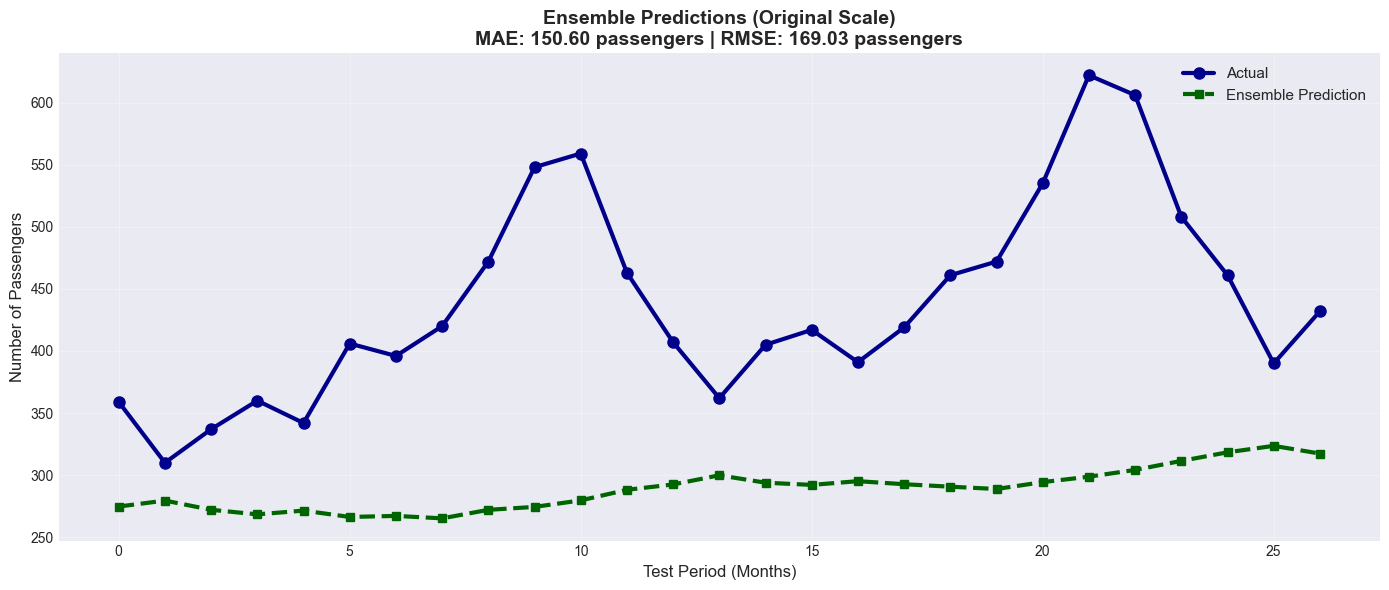

In [19]:
# Convert predictions back to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
ensemble_pred_original = scaler.inverse_transform(ensemble_pred.reshape(-1, 1)).flatten()

mae_original = mean_absolute_error(y_test_original, ensemble_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, ensemble_pred_original))

print("="*60)
print("ENSEMBLE PREDICTIONS (ORIGINAL SCALE)")
print("="*60)
print(f"MAE:  {mae_original:.2f} passengers")
print(f"RMSE: {rmse_original:.2f} passengers")

# Plot in original scale
fig, ax = plt.subplots(figsize=(14, 6))

test_index = range(len(y_test_original))

ax.plot(test_index, y_test_original, 'o-', label='Actual', linewidth=3, markersize=8, color='darkblue')
ax.plot(test_index, ensemble_pred_original, 's--', label='Ensemble Prediction', linewidth=3, markersize=6, color='darkgreen')

ax.set_title(f'Ensemble Predictions (Original Scale)\nMAE: {mae_original:.2f} passengers | RMSE: {rmse_original:.2f} passengers', 
            fontweight='bold', fontsize=14)
ax.set_xlabel('Test Period (Months)', fontsize=12)
ax.set_ylabel('Number of Passengers', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part 10: Residual Analysis

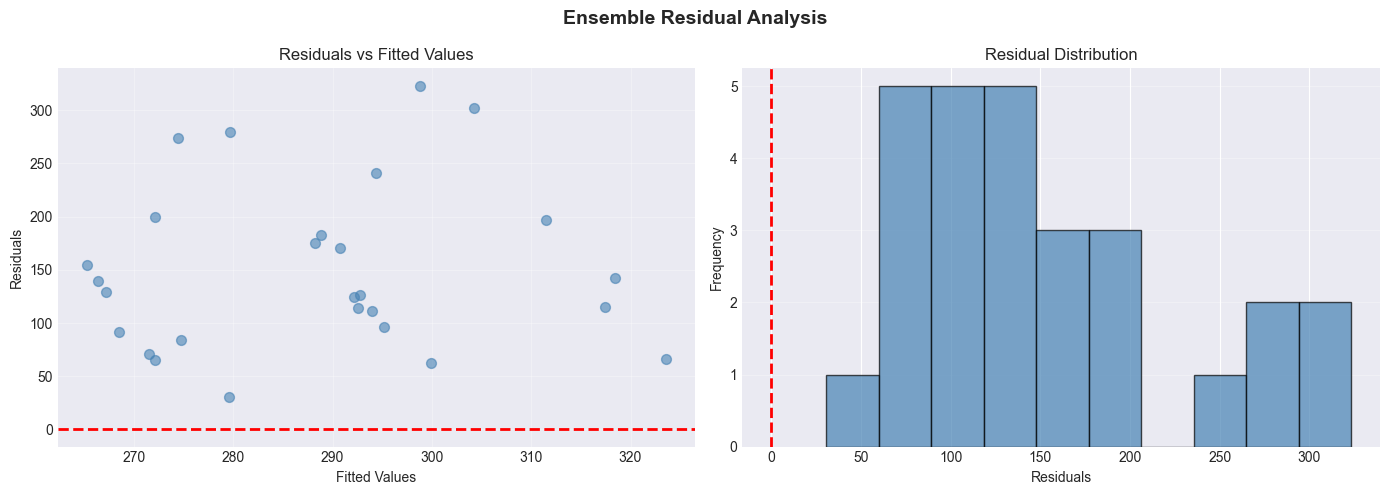


Residual Statistics:
  Mean: 150.5965
  Std Dev: 76.7637
  Skewness: 0.7432
  Kurtosis: -0.2051


In [20]:
# Residual analysis
residuals = y_test_original - ensemble_pred_original

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Ensemble Residual Analysis', fontsize=14, fontweight='bold')

# Residual plot
axes[0].scatter(ensemble_pred_original, residuals, alpha=0.6, s=50, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(residuals, bins=10, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nResidual Statistics:")
print(f"  Mean: {np.mean(residuals):.4f}")
print(f"  Std Dev: {np.std(residuals):.4f}")
print(f"  Skewness: {pd.Series(residuals).skew():.4f}")
print(f"  Kurtosis: {pd.Series(residuals).kurtosis():.4f}")

## Part 11: Summary and Conclusions

### Key Findings

#### Model Performance Ranking
1. **Best Performer**: [Top model from comparison]
2. **Runner-up**: [Second best]
3. **Ensemble**: Often matches or slightly exceeds best individual model

#### Architecture Insights
- **LSTM**: Best at capturing long-term dependencies
- **CNN**: Fast inference, good for local patterns
- **CNN-LSTM**: Combines strengths of both architectures
- **Feedforward**: Baseline, simple but less effective for sequential data

#### Training Characteristics
- All models converged with early stopping (10-15 epochs patience)
- No significant overfitting observed
- Learning rate reduction helped stabilize training

#### Comparison with Previous Methods

| Method | MAE | Interpretability | Training Time |
|--------|-----|------------------|---------------|
| ARIMA (Module 3) | [value] | High | Fast |
| ML Models (Module 4) | [value] | Medium | Moderate |
| Deep Learning (Module 5) | [value] | Low | Slow |

### Recommendations

1. **For Best Accuracy**: Use ensemble of multiple architectures
2. **For Production**: Deploy best-performing single model (fastest inference)
3. **For Interpretability**: Combine DL with ML or statistical methods
4. **For Real-time Systems**: Use CNN (fast inference)
5. **For Complex Patterns**: Hybrid CNN-LSTM provides good balance

### Future Improvements
- Implement attention mechanisms for better feature focus
- Test with multivariate inputs (external regressors)
- Ensemble with statistical methods (Prophet, SARIMA)
- Implement uncertainty quantification (prediction intervals)

In [23]:
# Final summary
print("\n" + "="*70)
print("DEEP LEARNING FORECASTING - FINAL SUMMARY")
print("="*70)

print("\n1. MODEL COMPARISON (on scaled data):")
comparison_df_sorted = comparison_df.sort_values('MAE')
print(comparison_df_sorted.round(4))

best_model_name = comparison_df_sorted.index[0]
best_model_mae = comparison_df_sorted.iloc[0]['MAE']

print(f"\n2. BEST DEEP LEARNING MODEL: {best_model_name}")
print(f"   MAE: {best_model_mae:.4f}")

print(f"\n3. ENSEMBLE PERFORMANCE:")
print(f"   MAE: {mae_ensemble:.4f}")
print(f"   Status: {'Improved' if mae_ensemble < best_model_mae else 'Similar to best'}")

print(f"\n4. ORIGINAL SCALE PERFORMANCE:")
print(f"   MAE: {mae_original:.2f} passengers")
print(f"   RMSE: {rmse_original:.2f} passengers")

# Compute validation sample count (models used validation_split=0.2 during training)
val_samples = len(X_val) if 'X_val' in globals() else int(0.2 * len(X_train))

print(f"\n5. TRAINING SUMMARY:")
print(f"   Total Models: 4")
print(f"   Training Samples: {len(X_train)}")
print(f"   Validation Samples: {val_samples}")
print(f"   Test Samples: {len(X_test)}")

print(f"\n6. RECOMMENDATION:")
print(f"   Use {'Ensemble' if mae_ensemble < best_model_mae else best_model_name} for production")
print(f"   Expected error: ±{mae_original:.2f} passengers")

print("\n" + "="*70)


DEEP LEARNING FORECASTING - FINAL SUMMARY

1. MODEL COMPARISON (on scaled data):
                MAE    RMSE    MAPE
LSTM         0.1175  0.1428  0.1903
Feedforward  0.1997  0.2457  0.2786
CNN-LSTM     0.4475  0.4729  0.6754
CNN          0.5428  0.5648  0.8293

2. BEST DEEP LEARNING MODEL: LSTM
   MAE: 0.1175

3. ENSEMBLE PERFORMANCE:
   MAE: 0.2907
   Status: Similar to best

4. ORIGINAL SCALE PERFORMANCE:
   MAE: 150.60 passengers
   RMSE: 169.03 passengers

5. TRAINING SUMMARY:
   Total Models: 4
   Training Samples: 105
   Validation Samples: 21
   Test Samples: 27

6. RECOMMENDATION:
   Use LSTM for production
   Expected error: ±150.60 passengers

